# PDF Parsing and Multimodal Summarization with Ollama

This notebook demonstrates a complete workflow for processing PDF documents using a custom-built Python library. The process involves:

1.  **Configuration**: Loading settings for the LLM and file paths from a `config.yaml` file.
2.  **Initialization**: Setting up the necessary components:
    *   `PdfParser`: To extract text, tables, and images from a PDF.
    *   `OllamaClient`: To communicate with a locally running Ollama instance.
    *   `MultimodalSummarizer`: To orchestrate the summarization of different content types (text, tables, images) using prompts.
3.  **Parsing**: Processing a sample PDF to break it down into a structured list of `DocumentChunk` objects.
4.  **Summarization**: Sending individual chunks to the Ollama vision model (`granite3.2-vision`) to generate summaries for each part.
5.  **Review**: Displaying the original content alongside its generated summary to verify the results.

## 1. Setup and Imports

First, we set up the environment by adding the project's `src` directory to the Python path. This allows us to import our custom modules. We then import all necessary libraries and our custom classes.

In [1]:
import os
import sys
import yaml
import logging
from pathlib import Path
import base64
from IPython.display import display, Markdown, Image

# Add the project root to the Python path to allow for module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
print(f"Project root added to path: {project_root}")

# Import custom modules from the 'src' directory
from src.processing.parsers.pdf_parser import PdfParser
from src.llm.ollama_client import OllamaClient
from src.summarization.multimodal_summarizer import MultimodalSummarizer

Project root added to path: /Users/javicm/dev/RAG-in-a-Box


## 2. Configuration and Logging

We load the configuration from `src/config.yaml` to get the Ollama model details and prompt file paths. We also set up basic logging to see the informational output from our modules during execution.

In [2]:
# Configure logging to display info messages
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load configuration from the YAML file
CONFIG_PATH = Path(project_root) / 'src' / 'config.yaml'
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully:")
print(yaml.dump(config, indent=2))

Configuration loaded successfully:
llm:
  ollama:
    generator_model: granite3.2-vision:latest
    host: http://localhost:11434
    summarizer_model: granite3.2-vision:latest
  provider: ollama
paths:
  prompts_dir: prompts
prompts:
  summarize_image: summarize_img.txt
  summarize_table: summarize_table.txt
  summarize_text: summarize_text.txt



## 3. Initialize Core Components

Now we instantiate the main classes of our application using the loaded configuration.

-   **`PdfParser`**: Ready to process PDF files.
-   **`OllamaClient`**: Connects to the Ollama server and specifies which model to use. **Ensure your Ollama server is running and the specified model is pulled (`ollama pull granite3.2-vision:latest`).**
-   **`MultimodalSummarizer`**: Links the LLM client with the appropriate prompt templates.

In [4]:
# 1. Initialize the PDF Parser
parser = PdfParser()

# 2. Initialize the Ollama LLM Client
llm_config = config['llm']['ollama']
try:
    ollama_client = OllamaClient(
        host=llm_config['host'],
        model=llm_config['summarizer_model']
    )
except Exception as e:
    logging.error(f"Failed to initialize Ollama Client: {e}")
    logging.error("Please ensure the Ollama application is running and the model is available.")

# 3. Initialize the Multimodal Summarizer
prompts_dir = Path(project_root) / config['paths']['prompts_dir']
prompt_templates = {
    'text': prompts_dir / config['prompts']['summarize_text'],
    'image': prompts_dir / config['prompts']['summarize_image'],
    'table': prompts_dir / config['prompts']['summarize_table'],
}

summarizer = MultimodalSummarizer(
    llm_client=ollama_client,
    prompt_templates=prompt_templates
)

logging.info("All components initialized successfully.")

2025-07-09 17:13:43,727 - INFO - Initializing PdfParser with image scale: 2.0
2025-07-09 17:13:43,738 - INFO - Ollama client initialized for model 'granite3.2-vision:latest' on host 'http://localhost:11434'.
2025-07-09 17:13:43,749 - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"
2025-07-09 17:13:43,749 - INFO - Model 'granite3.2-vision:latest' verified and available in Ollama.
2025-07-09 17:13:43,749 - INFO - Multimodal Summarizer initialized with external prompt templates.
2025-07-09 17:13:43,750 - INFO - All components initialized successfully.


## 4. Parse a PDF Document

We select a PDF from the `data/pdf` directory and use our `PdfParser` instance to process it. The parser will iterate through the document, extracting text, tables, and images in sequential order, and return a list of `DocumentChunk` objects.

In [5]:
PDF_DIR = Path(project_root) / 'data' / 'pdf'
# You can change this to any PDF in the 'data/pdf' folder
PDF_FILE = PDF_DIR / 'attention_is_all_you_need.pdf'

print(f"Parsing document: {PDF_FILE.name}")
chunks = parser.parse(PDF_FILE)

# Display parsing statistics
text_chunks_count = len(parser.get_text_chunks())
table_chunks_count = len(parser.get_table_chunks())
image_chunks_count = len(parser.get_image_chunks())

display(Markdown(f"""
### Parsing Complete
- **Total Chunks Extracted:** {len(chunks)}
    - **Text Chunks:** {text_chunks_count}
    - **Table Chunks:** {table_chunks_count}
    - **Image Chunks:** {image_chunks_count}
"""))

2025-07-09 17:13:47,075 - INFO - Starting to parse PDF: attention_is_all_you_need.pdf
2025-07-09 17:13:47,076 - INFO - Loading document from: attention_is_all_you_need.pdf
2025-07-09 17:13:47,079 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-07-09 17:13:47,115 - INFO - Going to convert document batch...
2025-07-09 17:13:47,115 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 1839ac7b8f395811156cc7d3e509f667
2025-07-09 17:13:47,123 - INFO - Loading plugin 'docling_defaults'
2025-07-09 17:13:47,125 - INFO - Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']


Parsing document: attention_is_all_you_need.pdf


2025-07-09 17:13:48,614 - INFO - Accelerator device: 'mps'
/Users/javicm/dev/RAG-in-a-Box/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-09 17:13:50,896 - INFO - Accelerator device: 'mps'
2025-07-09 17:13:52,055 - INFO - Accelerator device: 'mps'
2025-07-09 17:13:52,370 - INFO - Loading plugin 'docling_defaults'
2025-07-09 17:13:52,372 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-07-09 17:13:52,372 - INFO - Processing document attention_is_all_you_need.pdf
/Users/javicm/dev/RAG-in-a-Box/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/javicm/dev/RAG-in-a-Box/.venv/lib/python3.12/site-packages/torch/


### Parsing Complete
- **Total Chunks Extracted:** 139
    - **Text Chunks:** 127
    - **Table Chunks:** 6
    - **Image Chunks:** 6


## 5. Summarize Different Chunk Types

Let's test the summarizer on one of each type of chunk extracted from the document.

### 5.1. Text Chunk Summary

We'll select a text chunk, display its content, and then pass it to the summarizer.

In [6]:
text_chunks = parser.get_text_chunks()

if text_chunks:
    # Select a text chunk to summarize (e.g., the 6th chunk, which is often a good size)
    text_chunk_to_summarize = text_chunks[18] # <--- Chunk nº

    display(Markdown(f"**Original Text (Page {text_chunk_to_summarize.source_page}):**\n\n> "
                     f"{text_chunk_to_summarize.content.replace('\n', ' ')}"))

    # Generate the summary
    text_summary = summarizer.summarize_chunk(text_chunk_to_summarize)

    display(Markdown(f"**Generated Summary:**\n\n{text_summary}"))
else:
    print("No text chunks found in the document.")

**Original Text (Page 2):**

> Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38, 24, 15].

2025-07-09 17:14:11,308 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:11,310 - INFO - Summary generated for chunk of type 'text': 'Recurrent neural networks (RNNs), specifically long short-term memory (LSTM) and gated recurrent uni...'


**Generated Summary:**

Recurrent neural networks (RNNs), specifically long short-term memory (LSTM) and gated recurrent units (GRUs), have been widely used for sequence modeling and transduction tasks like language modeling and machine translation. Despite their success, researchers continue to advance RNN architectures in these areas.

### 5.2. Table Chunk Summary

Tables are converted to images by the `PdfParser`. We display the table image and then ask the vision model to summarize its contents.

**Original Table (as Image) from Page 6:**

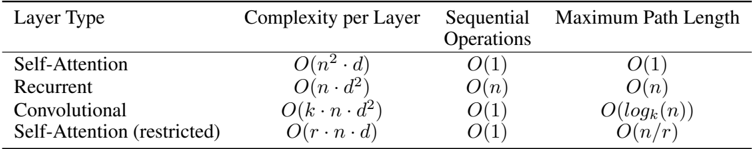

_Caption: Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types. n is the sequence length, d is the representation dimension, k is the kernel size of convolutions and r the size of the neighborhood in restricted self-attention._ 

2025-07-09 17:14:27,217 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:27,220 - INFO - Summary generated for chunk of type 'table': '# Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations fo...'


**Generated Summary:**

# Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types.

| Layer Type | Complexity per Layer Operations | Sequential Operations | Maximum Path Length |
|-----------------|-----------------------------------|---------------------------|-------------------------|
| Self-Attention   | O(n^2 · d)                        | O(1)                      | O(1)                    |
| Recurrent        | O(n · d^2)                       | O(n)                      | O(n)                    |
| Convolutional    | O(k · n · d^2)                     | O(1)                      | O(log k (n))            |
| Self-Attention (restricted) | O(r · n · d)                     | O(1)                      | O(n/r)                 |

In [7]:
table_chunks = parser.get_table_chunks()

if table_chunks:
    # Select the first table chunk
    table_chunk_to_summarize = table_chunks[0]

    display(Markdown(f"**Original Table (as Image) from Page {table_chunk_to_summarize.source_page}:**"))
    display(Image(data=base64.b64decode(table_chunk_to_summarize.content)))
    if caption := table_chunk_to_summarize.metadata.get("caption"):
        display(Markdown(f"_Caption: {caption}_ "))

    # Generate the summary
    table_summary = summarizer.summarize_chunk(table_chunk_to_summarize)

    display(Markdown(f"**Generated Summary:**\n\n{table_summary}"))
else:
    print("No table chunks found in the document.")

### 5.3. Image Chunk Summary

Finally, we do the same for a regular image found in the PDF. We display it and generate a descriptive summary.

**Original Image from Page 3:**

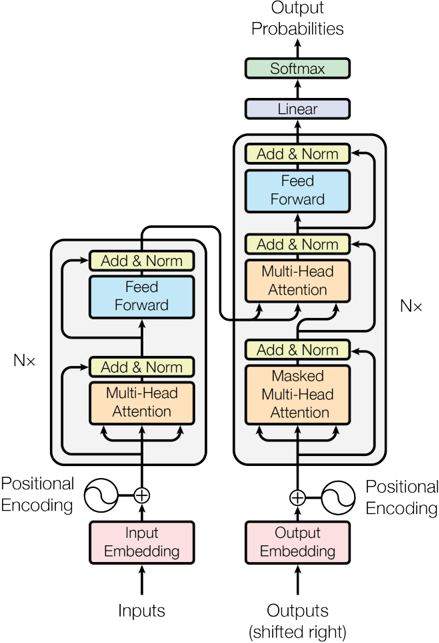

_Caption: Figure 1: The Transformer - model architecture._ 

2025-07-09 17:14:45,523 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:45,524 - INFO - Summary generated for chunk of type 'image': 'The image is a flowchart that illustrates the architecture of a transformer model. It depicts two ma...'


**Generated Summary:**

The image is a flowchart that illustrates the architecture of a transformer model. It depicts two main components on either side of the central axis, each with its own set of layers and processes. On the left side, there's an input embedding layer followed by multiple multi-head attention layers, then another multi-head attention layer, and finally an output embedding layer. The right side mirrors this structure but includes a softmax function at the end, which is typically used to normalize the outputs of the model into probabilities for each class.

The flowchart also includes arrows indicating the direction of data flow within the model. For example, from the input embedding layer, the data flows through the multi-head attention layers and then to the output embedding layer. The softmax function is shown at the end, suggesting that it takes the outputs of the previous layers as inputs and transforms them into probabilities for each class.

The image also includes a caption "Figure 1: The Transformer - model architecture," which provides context for the diagram's purpose. It indicates that this flowchart represents the structure of a transformer model, which is a type of neural network architecture used primarily in natural language processing tasks.

In [8]:
image_chunks = parser.get_image_chunks()

if image_chunks:
    # Select the first image chunk
    image_chunk_to_summarize = image_chunks[0]

    display(Markdown(f"**Original Image from Page {image_chunk_to_summarize.source_page}:**"))
    display(Image(data=base64.b64decode(image_chunk_to_summarize.content)))
    if caption := image_chunk_to_summarize.metadata.get("caption"):
        display(Markdown(f"_Caption: {caption}_ "))

    # Generate the summary
    image_summary = summarizer.summarize_chunk(image_chunk_to_summarize)

    display(Markdown(f"**Generated Summary:**\n\n{image_summary}"))
else:
    print("No image chunks found in the document.")

## 6. Generate Full Document Summary (By Chunk)

To create a summary of the entire document, we can iterate through all the chunks we extracted, generate a summary for each one, and then combine them. This provides a detailed, chunk-by-chunk overview of the PDF's content.

In [9]:
full_document_summaries = []
total_chunks = len(parser.chunks)

# Limiting to first 5 chunks for a quick demonstration. Remove the limit to process the whole document.
CHUNKS_TO_PROCESS = 5 

for i, chunk in enumerate(parser.chunks[:CHUNKS_TO_PROCESS]):
    print(f"--- Processing chunk {i+1}/{total_chunks} (Type: {chunk.type}, Page: {chunk.source_page}) ---")
    try:
        summary = summarizer.summarize_chunk(chunk)
        full_document_summaries.append(summary)
        print(summary)
    except Exception as e:
        error_message = f"Error summarizing chunk {i+1}: {e}"
        print(error_message)
        full_document_summaries.append(f"[ERROR: {error_message}]")
    print("\n")

print("--- Full Document Summary Generation Complete ---")

--- Processing chunk 1/139 (Type: text, Page: 1) ---


2025-07-09 17:14:45,975 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:45,977 - INFO - Summary generated for chunk of type 'text': 'Summary: Google grants permission to reproduce tables and figures in this paper for journalistic or ...'


Summary: Google grants permission to reproduce tables and figures in this paper for journalistic or scholarly use.


--- Processing chunk 2/139 (Type: text, Page: 1) ---


2025-07-09 17:14:47,207 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:47,208 - INFO - Summary generated for chunk of type 'text': '"Attention Is All You Need" is a paper published in 2017 that introduces the Transformer model, an a...'


"Attention Is All You Need" is a paper published in 2017 that introduces the Transformer model, an alternative to recurrent neural networks (RNNs) for natural language processing tasks. The Transformer model uses self-attention mechanisms to weigh the importance of input words and generate output sequences more efficiently than RNNs. It has since become a popular choice for various NLP applications, including machine translation, text summarization, and question answering.


--- Processing chunk 3/139 (Type: text, Page: 1) ---


2025-07-09 17:14:47,530 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:47,532 - INFO - Summary generated for chunk of type 'text': 'Ashish Vaswani is an individual associated with Google Brain....'


Ashish Vaswani is an individual associated with Google Brain.


--- Processing chunk 4/139 (Type: text, Page: 1) ---


2025-07-09 17:14:47,840 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:47,840 - INFO - Summary generated for chunk of type 'text': 'Summary: Noam Shazeer's contact information for Google Brain is provided....'


Summary: Noam Shazeer's contact information for Google Brain is provided.


--- Processing chunk 5/139 (Type: text, Page: 1) ---


2025-07-09 17:14:48,266 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-07-09 17:14:48,268 - INFO - Summary generated for chunk of type 'text': 'Summary: Niki Parmar is an individual associated with Google Research, identified by their email add...'


Summary: Niki Parmar is an individual associated with Google Research, identified by their email address nikip@google.com.


--- Full Document Summary Generation Complete ---


### Combined Full Summary

Here is the final, combined summary of all the processed chunks.

In [10]:
final_summary_text = "\n\n---\n\n".join(full_document_summaries)
display(Markdown(final_summary_text))

Summary: Google grants permission to reproduce tables and figures in this paper for journalistic or scholarly use.

---

"Attention Is All You Need" is a paper published in 2017 that introduces the Transformer model, an alternative to recurrent neural networks (RNNs) for natural language processing tasks. The Transformer model uses self-attention mechanisms to weigh the importance of input words and generate output sequences more efficiently than RNNs. It has since become a popular choice for various NLP applications, including machine translation, text summarization, and question answering.

---

Ashish Vaswani is an individual associated with Google Brain.

---

Summary: Noam Shazeer's contact information for Google Brain is provided.

---

Summary: Niki Parmar is an individual associated with Google Research, identified by their email address nikip@google.com.